# Example of how to read and parse the data file save from the rogue software

In [1]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
from scipy.stats import norm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
top_level=f'{os.getcwd()}/..'

In [2]:
def datfile(filename):
    # Waveforms variables to be filled 
    ampFault = { i : []  for i in range(4) }  
    xPosFault = []
    yPosFault = []
    qBunchFault = []
    recordtime = []
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/datfile/'+filename) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Check if there is a 8-byte header in the frame
            if (header.flags==0):
                hdrOffset = 8
                hdr = struct.unpack("<d", data[:8])[0]
                timestamp = time.localtime(hdr)
                # Define the desired format string (replace with your preferred format)
                # Some common format specifiers:
                # %Y - Year with century
                # %m - Month as a decimal number (01-12)
                # %d - Day of the month as a decimal number (01-31)
                # %H - Hour in 24-hour format (00-23)
                # %M - Minute (00-59)
                # %S - Second (00-59)
                
                formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S', timestamp)
                #print( f'CH={header.channel}: Event Timestamp in human-readable format: {formatted_time}' )
                if header.channel==24:
                    recordtime.append(formatted_time)
            
            else:
                hdrOffset = 0
                print( 'No timestamp header detected' )
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if AMP Fault waveform
            elif (header.channel < 16) and (header.channel >= 12):
                ampFault[header.channel-12].append(data[hdrOffset:].view(np.int16))
    
            # Check if AMP Live waveform
            elif header.channel == 24:
                fpData = data[hdrOffset:].view(np.float32)
                fpDataLen = len(fpData)
                xPosFault.append(   fpData[0:(fpDataLen*3)+0:3] ) 
                yPosFault.append(   fpData[1:(fpDataLen*3)+1:3] )
                qBunchFault.append( fpData[2:(fpDataLen*3)+2:3] )
            
            # Else undefined stream index
            else:
                print( f'UNDEFINED DATA STREAM[{header.channel}]!!!')
    return ampFault, recordtime

In [25]:
def make_heatmap(filename,eventnum):
    ampFault, recordtime=datfile(filename)
    print(f'abort time : {recordtime[eventnum]}')
    
    def bunchindex(threshold,waveform):
        start=12800
        for i in range(1,8*200):
            if waveform[start+i-1]<waveform[start+i] and waveform[start+i]>waveform[start+i+1]:
                if waveform[start+i]>threshold:
                    firstbunch=start+i
                    break
    
        bunch_candidate=waveform[firstbunch:firstbunch+5120*8:8]
        bunch_index=np.where(bunch_candidate>threshold)[0]
    
        return firstbunch, bunch_index

    firstbunch, bunch_index=bunchindex(2000,ampFault[0][eventnum])
    print(f'The number of bunch : {len(bunch_index)}')
    start=12800
    y_pos=[]
    for j in bunch_index:
        certain_bunch=[]
        for i in range(12):
            sum=ampFault[0][eventnum][firstbunch+j*8+5120*8*i]
            delta=ampFault[1][eventnum][firstbunch+j*8+5120*8*i]
            yposition=delta/sum*16.58/5+1.6
            certain_bunch.append(yposition)
        y_pos.append(np.array(certain_bunch))
    y_pos=np.array(y_pos)

    fig=plt.figure(figsize=(20,20))
    ax1=fig.add_subplot(2,2,1)
    ax2=fig.add_subplot(2,2,2)
    ax3=fig.add_subplot(2,2,3,projection='3d')
    
    im=ax1.imshow(y_pos,aspect=0.01,cmap='viridis',interpolation='none')
    plt.colorbar(im,label='Y position (mm)')
    ax1.set_xlabel("Turn")
    ax1.set_ylabel("Bunch ID")
    
    y_pos_diff=[]
    for i in range(y_pos.shape[0]):
        y_pos_diff.append(y_pos[i][1:]-y_pos[i][:-1])
        
    y_pos_diff=np.array(y_pos_diff)
    
    im2=ax2.imshow(y_pos_diff,aspect=0.01,cmap='viridis',interpolation='none')
    plt.colorbar(im2,label='Y pos diff (mm)')
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Bunch ID")

    x, y = np.meshgrid(np.arange(y_pos_diff.shape[1]), np.arange(y_pos_diff.shape[0]))
    surface = ax3.plot_surface(x, y, y_pos_diff, cmap='viridis')
    fig.colorbar(surface, ax=ax3, shrink=0.5, aspect=10)
    ax3.set_xlabel('Turn')
    ax3.set_ylabel('Bunch ID')
    ax3.set_zlabel('Y pos diff (mm)')
    ax3.set_zlim(-1,1)

    plt.show()

# 20240228_134811

26
2024-02-28_14-05-14


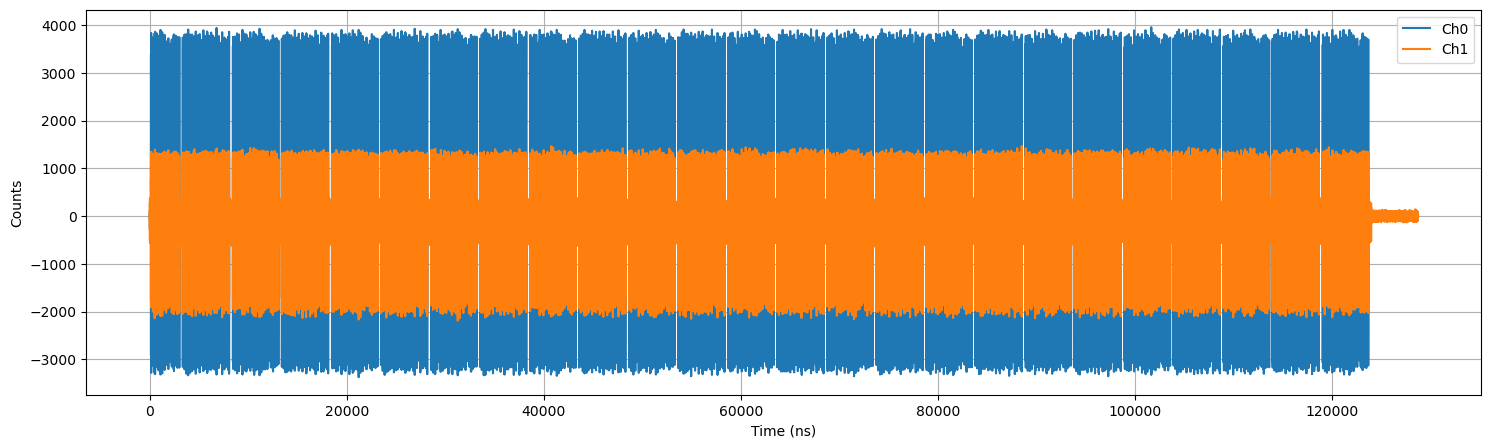

In [225]:
ampFault, recordtime=datfile("data_20240228_134811.dat")
print(len(recordtime))
eventnum=0
size = len(ampFault[0][eventnum])

print(recordtime[eventnum])
timeBin = 1.0/(0.509*8.0) # Unit of ns for 4.072 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.figure(figsize=(18,5))
plt.plot(timeSteps,ampFault[0][eventnum],label="Ch0")
plt.plot(timeSteps,ampFault[1][eventnum],label="Ch1")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
#plt.xlim(110000,130000)
plt.legend()
plt.grid()

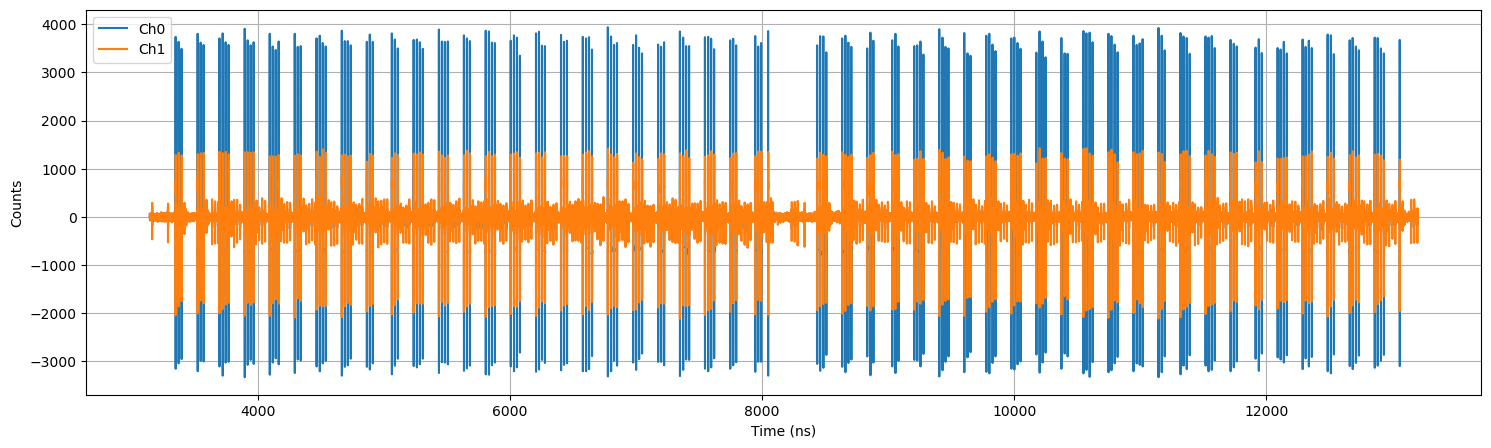

In [226]:
start=12800
stop=start+5120*8
plt.figure(figsize=(18,5))
plt.plot(timeSteps[start:stop],ampFault[0][eventnum][start:stop],label="Ch0")
plt.plot(timeSteps[start:stop],ampFault[1][eventnum][start:stop],label="Ch1")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
#plt.xlim(5000,6000)
plt.legend()
plt.grid()

abort time : 2024-02-28_14-05-14
The number of bunch : 180


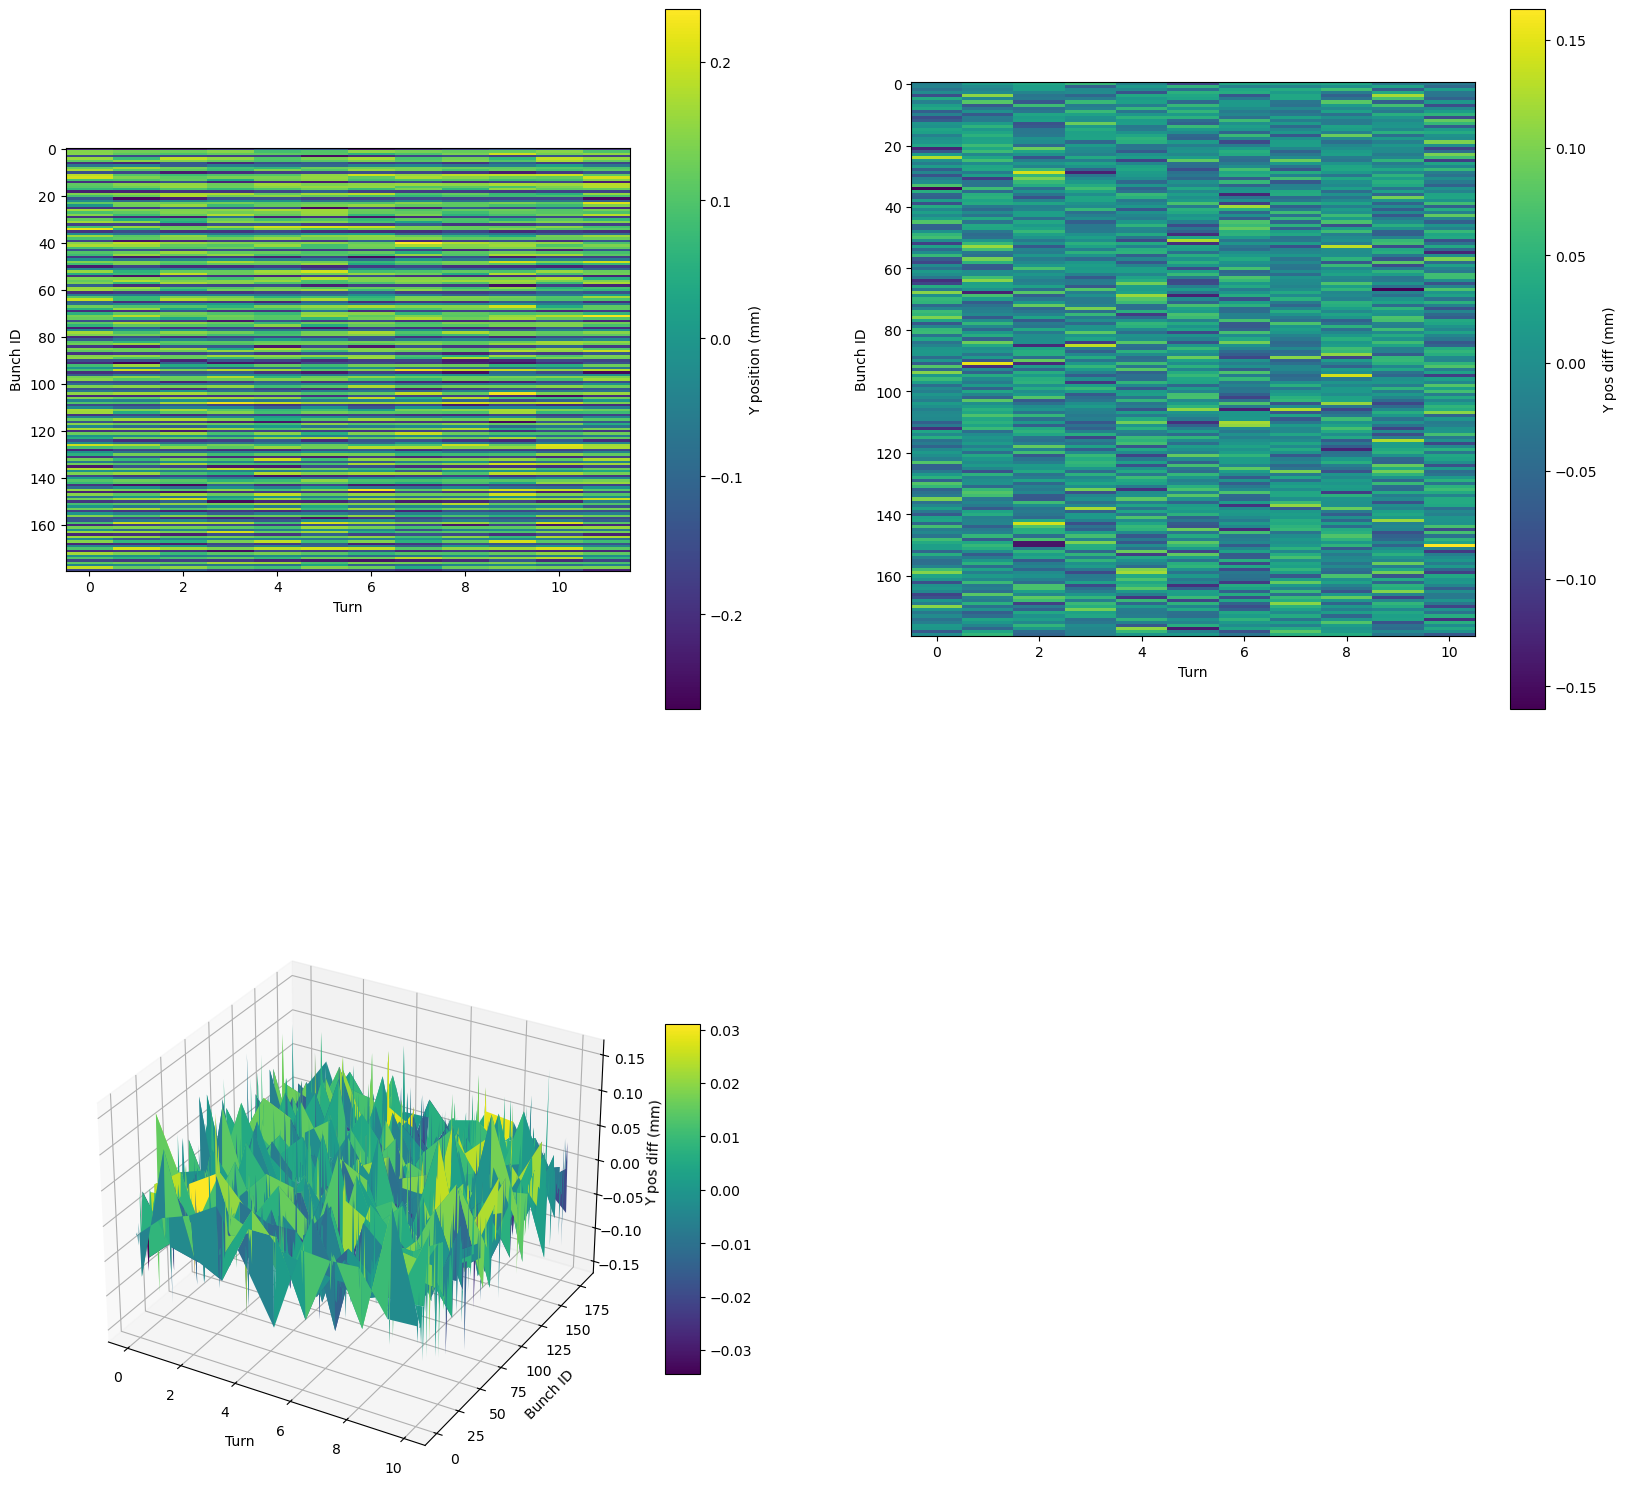

In [11]:
make_heatmap("data_20240228_134811.dat",0)

abort time : 2024-02-29_23-16-47
The number of bunch : 1449


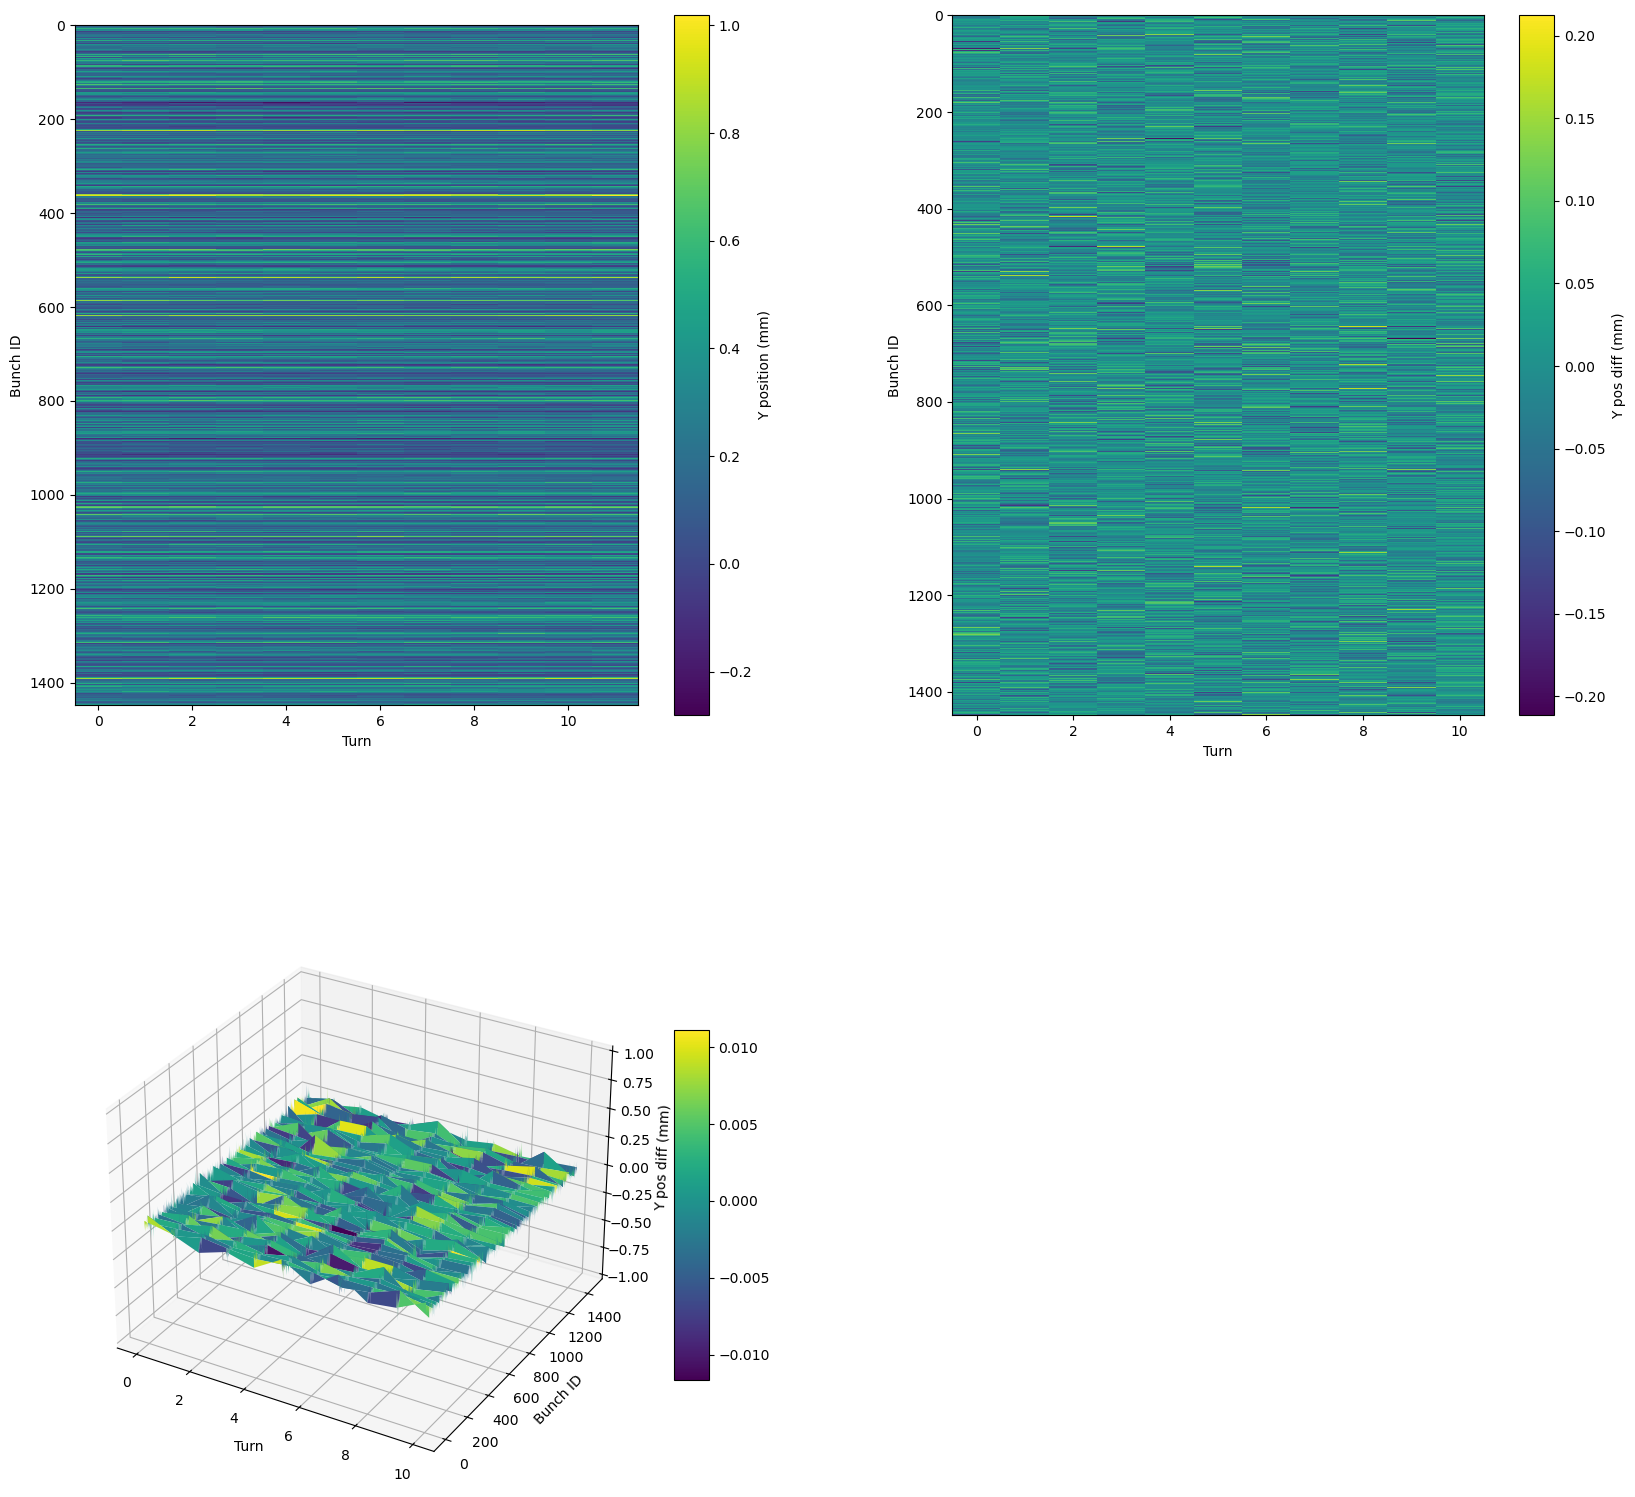

In [26]:
make_heatmap("data_20240229_205300.dat",0)